In [8]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from skimage.morphology import erosion, dilation,binary_erosion, opening, disk, closing
import skimage
import cv2

from skimage.filters.rank import entropy, median
from skimage.filters import threshold_otsu
from skimage import filters
from skimage import morphology

from skimage.morphology import thin
from skimage import io, filters
from tp2 import my_segmentation, evaluate, evaluate_2
from skimage import exposure
from scipy.fft import fft2, fftshift
from scipy.signal import convolve2d

from skimage import segmentation

from skimage.morphology import thin
from skimage.filters import frangi, hessian
import logging

import scipy

In [9]:
def plot_result_image(result_image):
    '''
        Function to plot original image, image to compare and output.
    '''

    f, axs = plt.subplots(1, 3, figsize=(15, 15))

    plt.subplot(1, 3, 1)  
    plt.imshow(original_image, cmap = 'gray')
    plt.title("Original")

    plt.subplot(1, 3, 2)  
    plt.imshow(img_GT, cmap = 'gray')
    plt.title('Verite Terrain')

    plt.subplot(1, 3, 3)  
    plt.imshow(result_image, cmap = 'gray')
    plt.title("Result Image")

    plt.show()

original_image =  np.array(Image.open('./images_IOSTAR/star01_OSC.jpg')).astype(np.uint8)
img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

# test_image = cv2.imread('./images_IOSTAR/star01_OSC.jpg', 1)

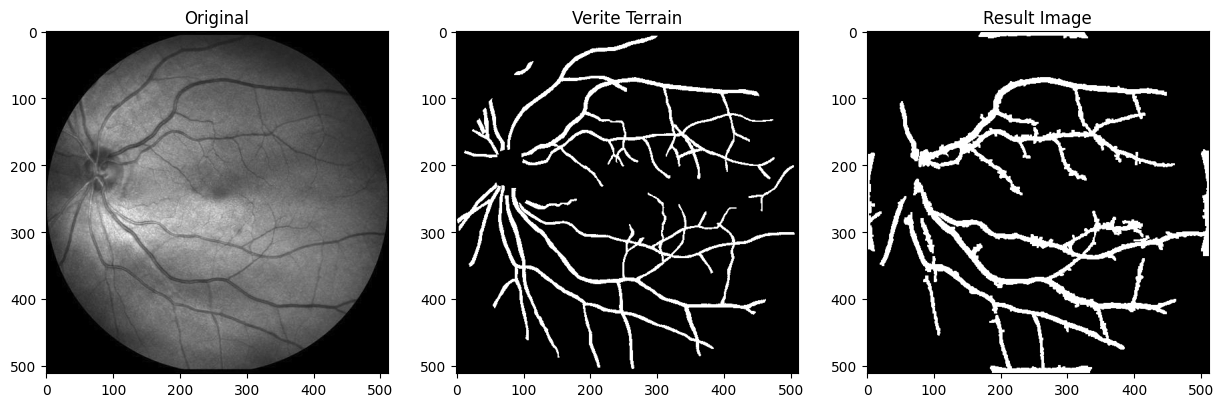

Accuracy = 0.7551534585432891, Recall = 0.6569037656903766


In [10]:
def charge_image(path):
    test_image = cv2.imread(path, 1)

    #test image is converted to LAB modal
    lab = cv2.cvtColor(test_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    #Contrast Limited Adaptive Histogram Equalization is applied
    clahe = cv2.createCLAHE(clipLimit=3.0)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))

    #LAB modal converted back to RGB
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return final

def apply_sequential_filtering(image, clipLimit=3.0):
    #applying alternate sequential filtering
    clahe = cv2.createCLAHE(clipLimit)

    blue,green,red = cv2.split(image)
    r1 = cv2.morphologyEx(green, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
    R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
    r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 1)
    R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 1)
    r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23,23)), iterations = 1)
    R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23,23)), iterations = 1)
    f4 = cv2.subtract(R3, green)
    filtered_image = clahe.apply(f4)

    return filtered_image

def apply_tophat_transformation(filtered_image, kernel_size=5):
    #tophat morphological transformation
    # image1 = f5
    e_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closeImg = cv2.morphologyEx(filtered_image, cv2.MORPH_CLOSE, e_kernel)
    revImg = closeImg
    topHat = filtered_image - revImg

    return topHat

def find_otsu(topHat, filtered_image):
    # #otsu with probability and minimization function
    # imge = topHat
    blur = cv2.GaussianBlur(topHat, (5,5), 0)
    hist = cv2.calcHist([blur], [0], None, [256], [0,256])
    hist_norm = hist.ravel()/hist.max()
    Q = hist_norm.cumsum()
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    for i in range(1, 256):
        p1, p2 = np.hsplit(hist_norm, [i]) #probabilities
        q1, q2 = Q[i],Q[255]-Q[i] #cum sum of classes
        b1, b2 = np.hsplit(bins,[i]) #weights

    #finding means and variances
    if q1 == 0:
        q1 = 0.0000001
    if q2 == 0:
        q2 = 0.0000001
    m1, m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1, v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

    #calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

    #find otsu&'s threshold value with OpenCV function
    ret, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    return otsu

def remove_contours(filtered_image, threshold_value=15, threshold_type=cv2.THRESH_BINARY, 
                    retrieval_mode=cv2.RETR_TREE, contour_approximation_mode=cv2.CHAIN_APPROX_SIMPLE):
    #removing very small contours through area parameter noise removal
    ret, f6 = cv2.threshold(filtered_image, threshold_value, 255, threshold_type)

    mask = np.ones(filtered_image.shape[:2], dtype='uint8') * 255
    contours, _ = cv2.findContours(f6.copy(), retrieval_mode, contour_approximation_mode)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 255:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    im = cv2.bitwise_and(filtered_image, filtered_image, mask=mask)

    return im

def remove(image, threshold_value=15, threshold_type=cv2.THRESH_BINARY, erode_size=3,
                morph_shape=cv2.MORPH_ELLIPSE):
    _, fin = cv2.threshold(image, threshold_value, 255, threshold_type)
    newfin = cv2.erode(fin, cv2.getStructuringElement(morph_shape, (erode_size,erode_size)), iterations=1)

    return newfin
    
def remove_blobs(newfin):
    #removing blobs of unwanted size
    fundus_eroded = cv2.bitwise_not(newfin)
    xmask = np.ones(fundus_eroded.shape[:2], dtype='uint8') * 255
    xcontours, _ = cv2.findContours(fundus_eroded.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in xcontours:
        shape = 'unidentified'
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
        if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
            shape = 'circle'
        else:
            shape = 'vessels'
        
        if(shape == 'circle'):
            cv2.drawContours(xmask, [cnt], -1, 0, -1)

    finimage = cv2.bitwise_and(fundus_eroded, fundus_eroded, mask=xmask)
    blood_vessels = cv2.bitwise_not(finimage)
    # kernel = np.ones((2,2), np.uint8)
    blood_vessels = cv2.subtract(255, blood_vessels)

    return blood_vessels
# -----------------------------------------------------------------
charged_image = charge_image('./images_IOSTAR/star01_OSC.jpg')
filtered_image = apply_sequential_filtering(charged_image, clipLimit=2)
topHat = apply_tophat_transformation(filtered_image)

newfin = remove_contours(filtered_image, 
                         threshold_value=15, 
                         threshold_type=cv2.THRESH_BINARY_INV, 
                         retrieval_mode=cv2.RETR_TREE, 
                         contour_approximation_mode=cv2.CHAIN_APPROX_SIMPLE)

newfin_2 = remove(newfin, 
                  threshold_value=15, 
                  threshold_type=cv2.THRESH_BINARY_INV, 
                  morph_shape=cv2.MORPH_RECT, 
                  erode_size=3)
                  
blood_vessels = remove_blobs(newfin_2)

plot_result_image(blood_vessels)
evaluate(blood_vessels.astype(np.uint8), img_GT)

In [11]:
threshold_types = [cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, 
                   cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV, cv2.THRESH_MASK,
                   cv2.THRESH_OTSU, cv2.THRESH_TRIANGLE]

retrieval_modes = [cv2.RETR_EXTERNAL, cv2.RETR_LIST, cv2.RETR_CCOMP, cv2.RETR_TREE, cv2.RETR_FLOODFILL]

contour_approximation_modes = [cv2.CHAIN_APPROX_NONE, cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_TC89_L1, cv2.CHAIN_APPROX_TC89_KCOS]

morph_shapes = [cv2.MORPH_RECT, cv2.MORPH_CROSS, cv2.THRESH_BINARY]

logging.basicConfig(filename='parameters.log', level=logging.INFO, format='%(asctime)s - %(message)s')

charged_image = charge_image('./images_IOSTAR/star01_OSC.jpg')
for clipLimit in range(1, 6):
    filtered_image = apply_sequential_filtering(charged_image, clipLimit=clipLimit)
    for threshold_value in range(5, 25):
        for threshold_type in threshold_types:
            for retrieval_mode in retrieval_modes:
                for contour_approximation_mode in contour_approximation_modes:
                    newfin = remove_contours(filtered_image, 
                                             threshold_value=threshold_value, 
                                             threshold_type=threshold_type, 
                                             retrieval_mode=retrieval_mode, 
                                             contour_approximation_mode=contour_approximation_mode)
                    for threshold_value_2 in range(5, 25):
                        for threshold_type_2 in threshold_types:
                            for morph_shape in morph_shapes:
                                for erode_size in range(1, 5):
                                    newfin_2 = remove(newfin, 
                                                    threshold_value=threshold_value_2, 
                                                    threshold_type=threshold_type_2, 
                                                    morph_shape=morph_shape, erode_size=3)
                                    blood_vessels = remove_blobs(newfin_2)
                                    ACCU, RECALL = evaluate_2(blood_vessels.astype(np.uint8), img_GT)
                                    logging.info(f'{clipLimit},{threshold_value},{threshold_type},{retrieval_mode},{contour_approximation_mode},{threshold_value_2},{threshold_type_2},{morph_shape},{erode_size},{ACCU},{RECALL}')



KeyboardInterrupt: 